In [1]:
import pandas as pd
import scipy.stats
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pyspark
from pyspark.sql import SparkSession
import os
import math
# Disable warnings, set Matplotlib inline plotting and load Pandas package
import warnings
warnings.filterwarnings('ignore')

# 1) Loading and preprocessing of data

In [ ]:
#This is needed to start a Spark session from the notebook
os.environ['PYSPARK_SUBMIT_ARGS'] ="--conf spark.driver.memory=2g\
                                    pyspark-shell"

# For Yarn, so that Spark knows where it runs
os.environ['HADOOP_CONF_DIR']="/etc/hadoop/conf"
# For Yarn, so Spark knows which version to use (and we want Anaconda to be used, so we have access to numpy, pandas, and so forth)
os.environ['PYSPARK_PYTHON']="/usr/local/anaconda3/bin/python3"
os.environ['PYSPARK_DRIVER_PYTHON']="/usr/local/anaconda3/bin/python3"


from pyspark.sql import SparkSession

In [ ]:

spark = SparkSession \
    .builder \
    .master("yarn") \
    .config("spark.executor.instances","5") \
    .appName("demoRDD") \
    .config('spark.ui.port', '4058') \
    .getOrCreate()

sc = spark.sparkContext
print(sc)



In [2]:
#This is needed to start a Spark session from the notebook
os.environ['PYSPARK_SUBMIT_ARGS'] ="--conf spark.driver.memory=4g  pyspark-shell"

spark = SparkSession \
    .builder \
    .master("local[3]") \
    .appName("Group2") \
    .config('spark.ui.port', '4058') \
    .getOrCreate()

sc = spark.sparkContext
print(sc)

<SparkContext master=local[3] appName=Group2>


In [ ]:
spark.stop()

## 1. Counting of unique items and features

### a) Features data

#### Loading items features data

In [3]:
# loading the features data and storing them in an rdd with the structure : 
#('item_id', ('feature_category_id', 'feature_value_id'))

featuresRDD = sc.textFile('dressipi_recsys2022/item_features.csv').map(lambda x: (x.split(',')[0], x.split(',')[1], x.split(',')[2])).filter(lambda x: x[0] != 'item_id')
featuresRDD = featuresRDD.map(lambda x: (int(x[0]), (int(x[1]), int(x[2]))))
featuresRDD.take(3)

[(2, (56, 365)), (2, (62, 801)), (2, (68, 351))]

#### unique item count in featuresRDD

In [4]:
# item_id are the keys of the pair rdd featuresRDD so with a groupByKey we get an rdd where each line corresponds to a unique item_id
unique_item = featuresRDD.groupByKey()
unique_item.count() 


23691

#### unique feature category and number of items per features counts

In [5]:
    #x[1][0] represents feature_category_id
feature_count = featuresRDD.map(lambda x: (x[1][0], 1)).reduceByKey(lambda x,y : x+y)
number_of_features = feature_count.count()
print('number of features : ' +str(number_of_features))


number of features : 73


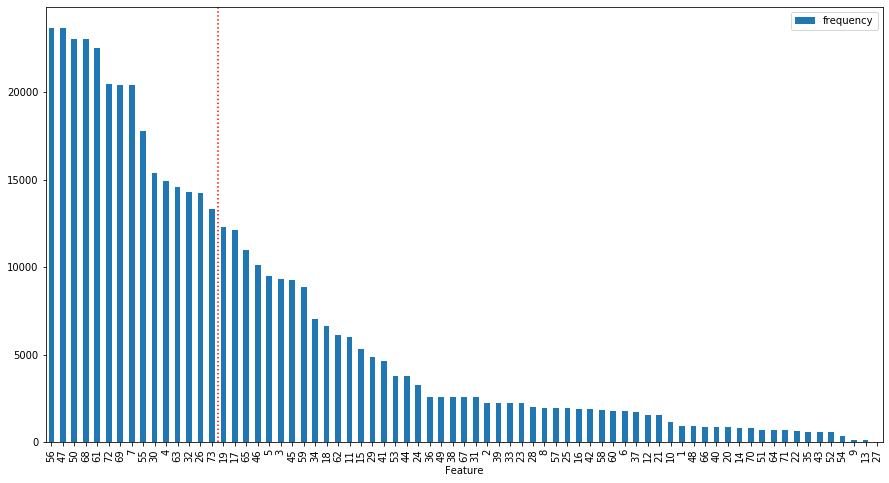

In [6]:
feature_histo = feature_count.sortBy(lambda x: -x[1]).collect()
df = pd.DataFrame(feature_histo, columns=['Feature', 'frequency'])
df.plot(kind='bar', x='Feature',figsize=(15,8))
plt.axvline(x = 14.5, color='r', linestyle='dotted')

In [8]:
max_items_features = feature_count.map(lambda x: x[1])
n = 13000 #threshold for the number of items for which the feature has a defined value
high_feature_count = feature_count.filter(lambda x : x[1] > n).count()
print(high_feature_count) 
feature_indices = feature_count.filter(lambda x : x[1] > n).map(lambda x: (x[0] - 1)).collect() #the feature_category_id go from 1 to 73 so their indices go from 0 to 72
print(feature_indices)

15
[55, 67, 71, 49, 31, 3, 25, 29, 60, 6, 68, 46, 72, 54, 62]


### b) Sessions data

#### load train_sessions 

In [9]:
# The item_id is chosen as the key and (session_id, timestamp) as the value
sessions_RDD = sc.textFile('dressipi_recsys2022/train_sessions.csv') \
    .map(lambda x: (x.split(',')[1], x.split(',')[0], x.split(',')[2])) \
    .filter(lambda x: x[0] != 'item_id') \
    .map(lambda x: (int(x[0]), (int(x[1]), datetime.strptime(x[2][:19], '%Y-%m-%d %H:%M:%S').timestamp(), 0)))
#0 indicates non purchased item
c = sessions_RDD.count()
print('#events = ' + str(c))
sessions_RDD.take(3)

#events = 4743820


[(9655, (3, 1608323100.0, 0)),
 (9655, (3, 1608322788.0, 0)),
 (15654, (13, 1584124527.0, 0))]

In [11]:
#first items
chronological_RDD = sessions_RDD.sortBy(lambda x: x[1][1])
chronological_RDD.take(1)

[(11234, (3747794, 1577833201.0, 0))]

#### number of feature appearing in more that n object's description

In [12]:
#last items
unchronological_RDD = sessions_RDD.sortBy(lambda x: -x[1][1])
unchronological_RDD.take(1)

[(17618, (3674124, 1622497413.0, 0))]

In [13]:
datetime.fromtimestamp(1622497413.0)

datetime.datetime(2021, 5, 31, 23, 43, 33)

In [14]:
#first and last and time between the 2
print(datetime.fromtimestamp(1577833201.0))
print(datetime.fromtimestamp(1622497413.0))
print(datetime.fromtimestamp(1622497413.0-1577833201.0)-datetime.fromtimestamp(0))

2020-01-01 00:00:01
2021-05-31 23:43:33
516 days, 22:43:32


#### Delete items consulted more than once in the same session (keep just 1 occurence per item)

In [15]:
# A new key (sess_id, item_id) is created (we want max 1 of each). The reduceByKey groups together the multiple
# occurences of an item in a session. Only the first occurence is kept
unique_sess_item = sessions_RDD.map(lambda x: ((x[0], x[1][0]),(x[1][1],x[1][2]))).reduceByKey(lambda x, y : x+y)
sessions_RDD = unique_sess_item.map(lambda x: (x[0][0], (x[0][1], x[1][0], x[1][1])))


#### Loading the purchased items data

In [16]:
P_sessions_RDD = sc.textFile('dressipi_recsys2022/train_purchases.csv') \
    .map(lambda x: (x.split(',')[1], x.split(',')[0], x.split(',')[2])) \
    .filter(lambda x: x[0] != 'item_id') \
    .map(lambda x: (int(x[0]), (int(x[1]), datetime.strptime(x[2][:19], '%Y-%m-%d %H:%M:%S').timestamp(), 1)))

P_sessions_RDD.take(3)

[(15085, (3, 1608323207.0, 1)),
 (18626, (13, 1584124575.0, 1)),
 (24911, (18, 1598462432.0, 1))]

#### Add purchased items to the dataset


In [17]:
all_sessions_RDD = sessions_RDD.union(P_sessions_RDD)

### c) Train-test split and undersampling the dataset

In [18]:
# we take the last month of the dataset as test set
t_end = datetime.strptime('2021-05-26 00:00:01', '%Y-%m-%d %H:%M:%S').timestamp()
test_sessions_RDD = reduced_sessions_RDD = all_sessions_RDD.filter(lambda x: x[1][1] > t_end)
print('count = ' + str(test_sessions_RDD.count()))
test_sessions_RDD.take(3)

count = 114253


[(19143, (261, 1622460918.0, 0)),
 (11998, (526, 1622183473.0, 0)),
 (5191, (937, 1622032133.0, 0))]

In [19]:
#sample a small part of the dataset to make the computations faster during the coding and debugging phases
reduced_sessions_RDD = all_sessions_RDD.filter(lambda x: x[1][1] < t_end).sample(False, 0.02)
print(reduced_sessions_RDD.count())

100108


In [20]:
#number of purchased items (which is = to the number of sessions) in the reduced dataset
reduced_purchased = reduced_sessions_RDD.filter(lambda x: x[1][2]==1)
reduced_purchased.count()

19646

#### unique item count from train_sessions

In [21]:
#number of unique items present in the reduced dataset (out of the ~24,000)
unique_item_list = reduced_sessions_RDD.groupByKey()
unique_item_count = unique_item_list.count()
print(unique_item_count)

15362


## 2. Reshaping the dataset

### a) Features

#### Verification that no feature has value 0 

In [22]:
# verification that no feature can take the value 0
zero_featuresRDD = featuresRDD.filter(lambda x: x[1][1] == 0)
zero_featuresRDD.collect()

[]

In [23]:
def sparse_tuple(x):   
    #x = tuple where x[0] is an index and x[1] a value
    #Creates a list (or tuple) with length 73 (72 zeros and x[1] at index [0])   
    res = [0,]*number_of_features
    res[x[0]-1] = x[1]
    #res = tuple(res)
    print('res : ' + str(res))
    #print(res)
    return res

def add_tuple(x, y, sign):    
    #Addition of tuple (or list) element per element  
    # sign = +1 or -1
    n = len(x)
    if n != len(y):
        raise Exception('x & y of different lengths')
    res = [0]*n
    for i in range(n):
        res[i] = x[i]+ sign * y[i]
    return(tuple(res))

def square_tuple(x):
    res = []
    for i in x:
        res.append(i**2)
    return res

def divide_tuple(vec):
    # a function to divide a input vector into a list of tuples of lengths 2
    res = []
    for i in range(len(vec)//2):
        res.append((vec[2*i], vec[2*i+1]))
    return res

def take_indices(vec, idx):
    # selection of items from a list from a list of indices
    res = []
    for i in idx:
        res.append(vec[i])
    return res


#### selection of the features describing the most items

In [24]:
# map the dataset to have on each line 70 items = 0, 1 item with the feature value 
dataset = featuresRDD.map(lambda x : (x[0], sparse_tuple(x[1])))
# reduction to merge all the lines of the same objects, to have one line with the 72 features for each item
dataset = dataset.reduceByKey(lambda x,y : add_tuple(x,y,1)).sortBy(lambda x: x[0]).map(lambda x: (x[0],x[1]))
count = dataset.count()
count

23691

In [25]:
items_dataset = dataset.map(lambda x: (x[0], take_indices(x[1], feature_indices))) 
items_dataset.take(3)
#now each item is described by a list of 15 features

[(2, [365, 351, 75, 76, 0, 0, 0, 0, 462, 394, 885, 123, 0, 0, 0]),
 (3, [365, 14, 75, 240, 902, 618, 268, 0, 706, 452, 592, 549, 544, 129, 861]),
 (4, [365, 373, 75, 317, 902, 618, 268, 0, 462, 837, 538, 218, 544, 267, 861])]

### b) Sessions

In [26]:
def reorder_tuple(row):
    # input of the function is the RDD which results from the join operation between reduced_session_RDD and items_dataset
    # the structure of the input is a tuple (item_id, ((session_id, timestamp, 0/1),[item features]))
    #the elements are reordered to get an output : (sess_id,(item_id, item_features))
    item_id = row[0]
    sess_id = row[1][0][0]
    timestamp = row[1][0][1]
    item_features = row[1][1] + [timestamp] #the timestamp is added to the features
    return (sess_id,(item_id, item_features))

def separate_lists(x, step):
    # x is a list with the features of all the objects of a session. The function separates this list to get a distinct list
    # for each object
    res = []
    for i in range(len(x) // step):
        res.append(x[step*i:step*(i+1)])
    return res


From the dataset and the train_sessions csv, we try to get a sessions dataset where each key is a session_id, 
and the value is a list of lists : a list of features for each item consulted during the session

In [27]:
# join the dataset with the sessions RDD in order to link the information from the 2 RDDs and get an RDD with the features and 
# timestamps of each object in each session
joined_RDD = reduced_sessions_RDD.join(items_dataset).map(lambda x: reorder_tuple(x))
# Reduce the RDD to have a single key for each session
reduced_joined_RDD = joined_RDD.reduceByKey(lambda x, y: x+y )
# Get a list of lists of features for each item
sessions_dataset = reduced_joined_RDD.map(lambda x: (x[0],separate_lists(x[1],2)))


In [28]:
sessions_dataset.take(1)

[(540,
  [(24760,
    [365,
     351,
     829,
     901,
     0,
     618,
     0,
     0,
     808,
     798,
     639,
     165,
     544,
     267,
     861,
     1591595712.0])])]

In [29]:
N_sessions = sessions_dataset.count()
print(N_sessions)

92044


## 3. Feature engineering

### A) Features computation

In [30]:
def merge_objects(sess):
    # takes as input a list of length = nb of objects in session, each item is the list of features descibing the object
    # returns a list of length = nb of features where each item is the values of each object for the feature
    print(sess)
    res = list(sess[0])
    for i in range(len(res)):
        res[i] = [res[i]]
    for i in range(len(res)):
        for j in range(1,len(sess)):
            res[i].append(sess[j][i])
    return res

def freq_ent(vec):
    #input : vector with the values of a given feature for the different objects in a session
    #for the item feature fi, the function computes the session features Fi, Ei and Fi/(1+Ei)
    #where Fi takes the nonzero value of fi that is the most frequent among the items in the session, and
    #Ei is the shannon entropy of the distribution of fi
    
    #frequencies is an array where each index corresponds to a feature value, and each element is the number of items in the session with this value
    frequencies = np.bincount(np.array(vec))
    #all the 0 in the frequencies array (corresponding to feature values not appearing in the input vec) are removed
    n_z_frequencies = frequencies[np.nonzero(frequencies)]
    e = float(entropy(n_z_frequencies))
    #the features with value 0 are features which have no defined value for the item, so they are ignored for the computation of Fi
    frequencies[0] = 0
    max_freq = int(frequencies.argmax())
    f_div_e = float(max_freq)/(1+e)
    return (max_freq, e, f_div_e)
    
def entropy(vec):
    #computes shannon entropy from frequencies vector
    res = 0
    n = sum(vec)
    if n <= 1:
        return 0
    else:
        probs = vec/n
        for i in probs:
            res -= (i * math.log(i, 2))
        return res 

def freq_ent_loop(vec):
    # takes as input the array with the values of the 15 objects features for all the items of the sessions 
    #(array of size n_features with each item in the array being an array of size n_objects in the session)
    
    #Computes the sessions features by looping on each of the 15 objects features. 
    #It computes -F : the value most frequent for the objects in the session
    #            -ent : the shannon entropy of the values that each feature takes on the different objects of the session
    #            -F_div_ent : F/(1+ent)
    F = []
    ent = []
    F_div_ent = []
    for i in vec:
        (f,e,fde) = freq_ent(i)
        F.append(f)
        ent.append(e)
        F_div_ent.append(fde)
    print('F : ' + str(F))
    print('ent : ' + str(ent))
    print('F_div_ent : ' + str(F_div_ent))
    return(F+ent+F_div_ent)


In [31]:
# for each session, put all the values for each features in an array (in other words : transpose the items/features matrix in each session)
sessions_features_counts = sessions_dataset.map(lambda x: (x[0], merge_objects([item[1][:15] for item in x[1]])))


In [32]:
sessions_features_counts.take(2)

[(540,
  [[365],
   [351],
   [829],
   [901],
   [0],
   [618],
   [0],
   [0],
   [808],
   [798],
   [639],
   [165],
   [544],
   [267],
   [861]]),
 (1188310,
  [[365],
   [351],
   [829],
   [901],
   [0],
   [618],
   [0],
   [0],
   [808],
   [798],
   [639],
   [165],
   [544],
   [267],
   [861]])]

In [33]:
# each session is mapped to an array of the session features (most frequent value for each item feature, and entropy of each
#item feature)
freq_ent_sessions = sessions_features_counts.map(lambda x: (x[0], freq_ent_loop(x[1])))

freq_ent_sessions.cache()
freq_ent_sessions.take(3)

[(540,
  [365,
   351,
   829,
   901,
   0,
   618,
   0,
   0,
   808,
   798,
   639,
   165,
   544,
   267,
   861,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   365.0,
   351.0,
   829.0,
   901.0,
   0.0,
   618.0,
   0.0,
   0.0,
   808.0,
   798.0,
   639.0,
   165.0,
   544.0,
   267.0,
   861.0]),
 (1188310,
  [365,
   351,
   829,
   901,
   0,
   618,
   0,
   0,
   808,
   798,
   639,
   165,
   544,
   267,
   861,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   365.0,
   351.0,
   829.0,
   901.0,
   0.0,
   618.0,
   0.0,
   0.0,
   808.0,
   798.0,
   639.0,
   165.0,
   544.0,
   267.0,
   861.0]),
 (7860,
  [365,
   106,
   75,
   317,
   0,
   618,
   0,
   0,
   462,
   394,
   885,
   123,
   544,
   267,
   861,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.

### B) Values imputations and normalizations

#### Replacing F features = 0 by the average of the feature over all sessions

In [34]:
# computation of the means and variances of the different features. (variances are not used here but just later for normalization)
sessions_features_means = freq_ent_sessions.map(lambda x: x[1]).reduce(lambda x, y: add_tuple(x,y,1))
means = np.array(sessions_features_means)/N_sessions
 #compute the square of the difference of each value with the mean of the feature
sessions_features_variance = freq_ent_sessions.map(lambda x: (square_tuple(add_tuple(x[1],means,-1))))
variances = sessions_features_variance.reduce(lambda x, y: add_tuple(x,y,1)) #computes the sum of the squares of the differences to the mean
std_dev = np.sqrt(np.array(variances)/N_sessions) #divides by the number of sessions to get the variance then takes the square root to take the standard deviation

In [35]:
def replace_zeros_sess(vec):
    #takes an array as input and replace the 0s by the value of the mean (broadcasted) of the corresponding index
    means = broadcasted_means.value
    for i in range(len(vec)):
        if int(vec[i]) == 0:
            vec[i] = means[i]
    return vec

def fill_features_vector(vec):
    #replaces the zeros of the 15 first and last features (but not the entropies) 
    vec[:15] = replace_zeros_sess(vec[:15])
    vec[30:] = replace_zeros_sess(vec[30:])
    return vec

In [37]:
#the means and standard deviation arrays are going to be used on every node for the normalization, so they are broadcasted here
broadcasted_means = sc.broadcast(means)
broadcasted_std_dev = sc.broadcast(std_dev)
filled_f_e_s = freq_ent_sessions.map(lambda x: (x[0], fill_features_vector(x[1])))
freq_ent_sessions.unpersist()

PythonRDD[90] at RDD at PythonRDD.scala:53

#### Normalization 

In [36]:
def standardize(vec):
    #computes the normalized version of the input array, given broadcasted arrays of means and standard deviations 
    means = broadcasted_means.value
    std_dev = broadcasted_std_dev.value
    n = len(vec)
    standardized_vec = []
    for i in range(n):
        res = (vec[i]-means[i])/std_dev[i]
        standardized_vec.append(res)
    return standardized_vec
        

In [38]:
# normalisation of the features
standardized_sessions_dataset = filled_f_e_s.map(lambda x: (x[0], standardize(x[1])))
standardized_sessions_dataset.cache()
standardized_sessions_dataset.take(3)

[(540,
  [0.03451268926377966,
   -0.34785072390272176,
   3.440498683591737,
   1.305801887517942,
   0.0,
   0.367416888644638,
   0.0,
   0.0,
   1.019151527818151,
   1.4252794389556989,
   -0.03601424103657584,
   -0.6344888447738743,
   0.5963526670851849,
   -0.15245280098823324,
   0.49218018929525464,
   -0.08025459916750374,
   -0.2566965611878411,
   -0.20040284239920123,
   -0.1766442901847516,
   -0.20865227161819014,
   -0.16833732175679217,
   -0.21671659410136565,
   -0.16581432873897423,
   -0.21392188551743074,
   -0.2447456351373295,
   -0.2386770361823572,
   -0.21909170775254466,
   -0.15341343532079338,
   -0.20238810043588956,
   -0.16596100633967942,
   0.04976929378192275,
   -0.2992901063614986,
   3.46548456216079,
   1.3085953318609314,
   0.030450979508648165,
   0.39690622303057016,
   0.030388436870097815,
   0.02622648278621914,
   1.0179606679298656,
   1.4525755164375753,
   0.03383560450175011,
   -0.6147763717166682,
   0.6129664674479756,
   -0.1243

### C) Preprosessing for the test set

In [78]:
#all the same operations are done to preprocess the test set, to use it in the validation phase of the prediction model (task 3)
test_joined_RDD = test_sessions_RDD.join(items_dataset).map(lambda x: reorder_tuple(x))
test_reduced_joined_RDD = test_joined_RDD.reduceByKey(lambda x, y: x+y )
test_sessions_dataset = test_reduced_joined_RDD.map(lambda x: (x[0],separate_lists(x[1],2)))
N_test_sessions = test_sessions_dataset.count()
test_sessions_features_counts = test_sessions_dataset.map(lambda x: (x[0], merge_objects([item[1][:15] for item in x[1]])))
test_freq_ent_sessions = test_sessions_features_counts.map(lambda x: (x[0], freq_ent_loop(x[1])))
test_freq_ent_sessions.cache()
test_freq_ent_sessions.take(1)
test_sessions_features_means = test_freq_ent_sessions.map(lambda x: x[1]).reduce(lambda x, y: add_tuple(x,y,1))
test_means = np.array(test_sessions_features_means)/N_test_sessions
test_sessions_features_variance = test_freq_ent_sessions.map(lambda x: (square_tuple(add_tuple(x[1],test_means,-1))))
test_variances = test_sessions_features_variance.reduce(lambda x, y: add_tuple(x,y,1)) 
test_std_dev = np.sqrt(np.array(test_variances)/N_test_sessions)
broadcasted_means = sc.broadcast(test_means)
broadcasted_std_dev = sc.broadcast(test_std_dev)
test_filled_f_e_s = test_freq_ent_sessions.map(lambda x: (x[0], fill_features_vector(x[1])))
#test_filled_f_e_s.take(2)
test_freq_ent_sessions.unpersist()
test_standardized_sessions_dataset = test_filled_f_e_s.map(lambda x: (x[0], standardize(x[1])))
test_standardized_sessions_dataset.take(1)

[(2100,
  [0.04364460273238785,
   -1.7376368225815568,
   -0.09408286568413429,
   0.03643496335047259,
   0.0,
   0.2741307974703113,
   0.0,
   0.338117077148136,
   -1.0908156036600443,
   0.05451374535816015,
   1.055659607936106,
   -0.7017484640396827,
   0.2538531420531715,
   -0.0446864292595035,
   0.28718170286894457,
   -0.23375909622120433,
   -0.15175818095527874,
   -0.969303662800613,
   3.1387000892598067,
   -1.0546910162311414,
   -0.7118359211450609,
   -1.0842523570002074,
   2.376635194620061,
   -1.352527952864886,
   -1.2562837259114215,
   -1.3397039734023781,
   -0.930315270585661,
   -0.5818495979339845,
   -1.0247859652047393,
   -0.7260181515690793,
   0.2403325869639175,
   -1.1827330623486263,
   0.26627231146511937,
   -1.548797549021643,
   0.739822024230788,
   0.7854512663949264,
   0.69982263580792,
   0.043218542902547306,
   0.35417450277898826,
   1.0115710819073283,
   2.187735233108575,
   -0.44658978967709717,
   0.5603360482575273,
   0.779116

### D) Plotting the distribution of the different variables

#### Plot entropies

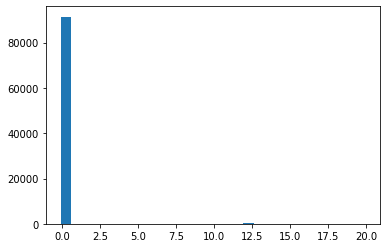

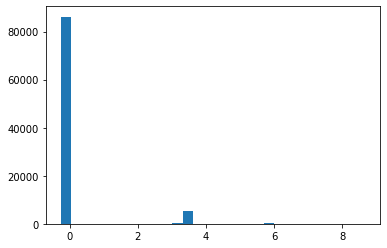

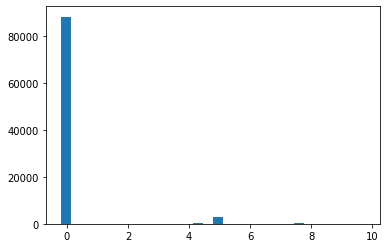

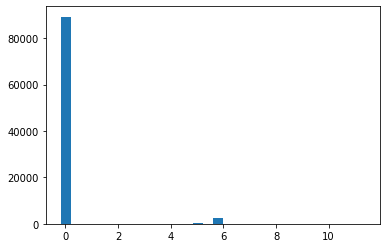

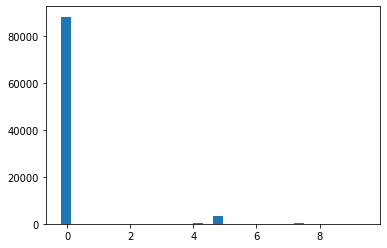

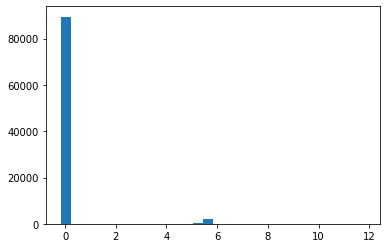

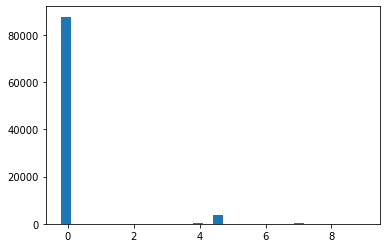

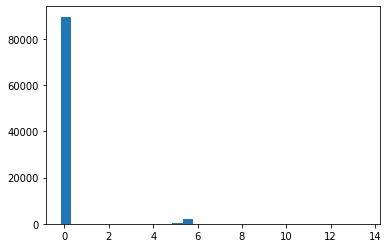

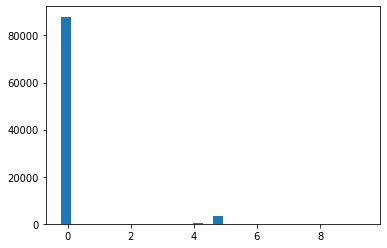

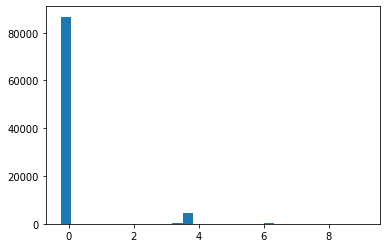

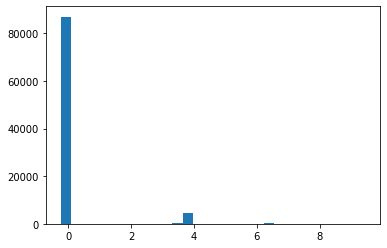

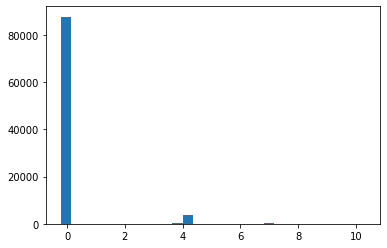

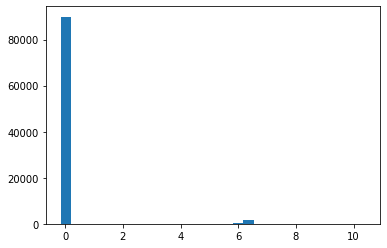

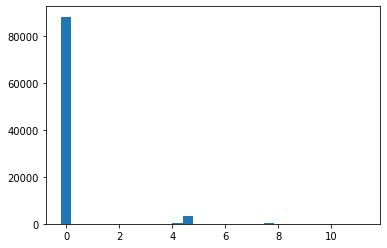

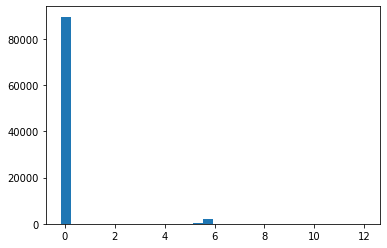

In [40]:
entropies = np.transpose(np.array(standardized_sessions_dataset.map(lambda x:x[1][15:30]).collect()))
for i in entropies:
    plt.figure()
    n, bins, patches = plt.hist(i, 30)

#### Plot Fi/(1+Ei)

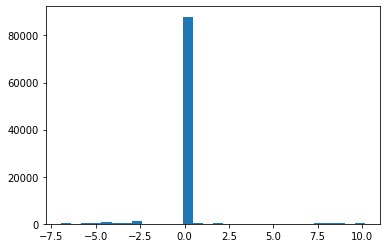

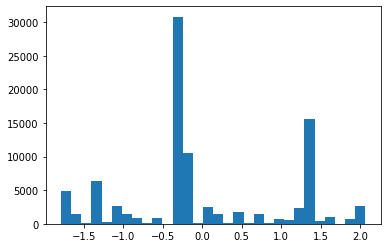

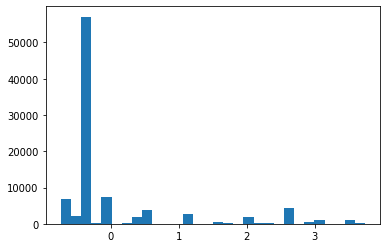

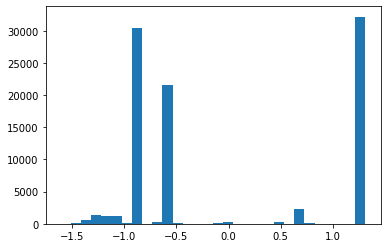

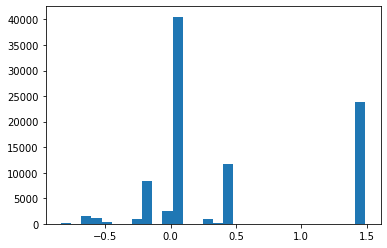

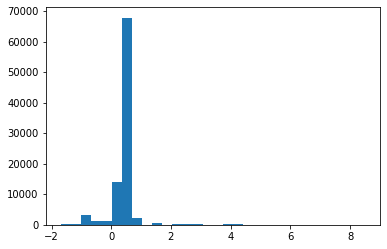

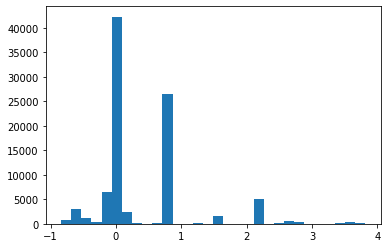

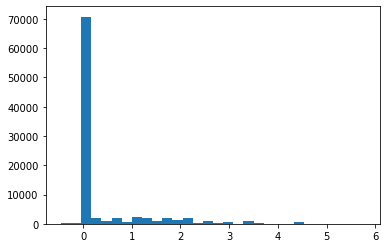

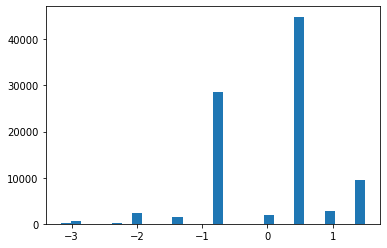

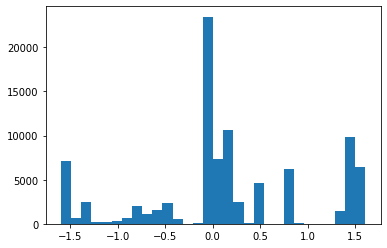

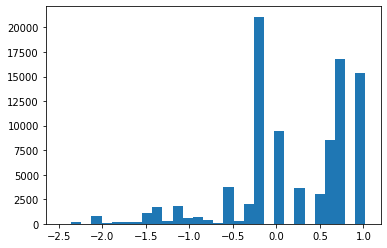

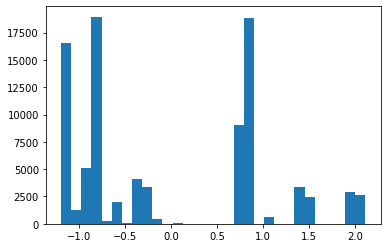

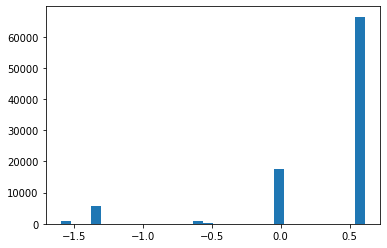

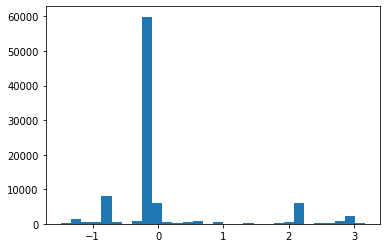

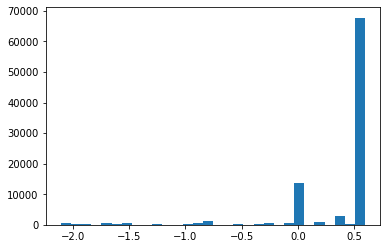

In [41]:
inv_ent2 = np.transpose(np.array(standardized_sessions_dataset.map(lambda x:x[1][30:]).collect()))
for i in inv_ent2:
    plt.figure()
    n, bins, patches = plt.hist(i, 30)

# 2) Feature selection

### A) Computation of the variables : X = difference between sessions features, Y = distances between session's purchased items

As the output is computed as the euclidian distance between purchased items in the items feature space, we start by modifying items_dataset to replace the 0s by the average of each feature, and normalize the items features (in the previous section the sessions features were normalized).

In [42]:
def replace_zeros(vec, means):
    for i in range(len(vec)):
        if int(vec[i]) == 0:
            vec[i] = means[i]
    return vec


In [43]:
N_items = items_dataset.count()
means = items_dataset.map(lambda x: np.array(x[1])).reduce(lambda x,y: x+y)/N_items
broadcasted_means = sc.broadcast(means)
means

array([360.18986113, 431.2718754 , 165.29542864, 470.52762652,
       386.64796758, 383.93866869, 170.32379385, 341.29834114,
       643.19982272, 428.4691233 , 592.38482968, 381.64813642,
       260.76666245, 257.04465831, 490.31813769])

In [44]:
filled_items_dataset = items_dataset.map(lambda x: (x[0], replace_zeros_sess(x[1])))
filled_items_dataset.take(2)

[(2,
  [365,
   351,
   75,
   76,
   386.64796758262634,
   383.9386686927525,
   170.32379384576421,
   341.2983411422059,
   462,
   394,
   885,
   123,
   260.76666244565445,
   257.0446583090625,
   490.31813768941794]),
 (3,
  [365,
   14,
   75,
   240,
   902,
   618,
   268,
   341.2983411422059,
   706,
   452,
   592,
   549,
   544,
   129,
   861])]

#### Normalization of the items features

In [45]:
items_features_variance = filled_items_dataset.map(lambda x: (square_tuple(add_tuple(x[1],means,-1))))
variances = items_features_variance.reduce(lambda x, y: add_tuple(x,y,1)) #computes the sum of the squares of the differences to the mean
std_dev = np.sqrt(np.array(variances)/N_items) #divides by the number of sessions to get the variance then takes the square root to take the standard deviation

In [47]:
std_dev

array([107.43610733, 227.91148168, 204.45134826, 281.97216321,
       287.82863653, 218.75871052, 142.14540964, 641.01766821,
       153.77588152, 246.17481624, 163.08215278, 262.01936413,
       200.0047702 , 192.25041475, 278.4988228 ])

In [46]:
broadcasted_std_dev = sc.broadcast(std_dev)

In [48]:
std_items_dataset = filled_items_dataset.map(lambda x: (x[0], standardize(x[1])))
std_items_dataset.take(3)

[(2,
  [0.04477208818117561,
   -0.35220636891030704,
   -0.4416475088716057,
   -1.3991722517491725,
   0.0,
   0.0,
   0.0,
   0.0,
   -1.178337076852414,
   -0.14001888504601998,
   1.794280767883323,
   -0.9871336695984818,
   0.0,
   0.0,
   0.0]),
 (3,
  [0.04477208818117561,
   -1.8308506105907774,
   -0.4416475088716057,
   -0.8175545553965027,
   1.7904821376540847,
   1.0699520524502326,
   0.6871569500827328,
   0.0,
   0.4083876916384377,
   0.09558604354427667,
   -0.002359728980751144,
   0.6387003652581997,
   1.4161329115649675,
   -0.6660305959605971,
   1.3309997456341864]),
 (4,
  [0.04477208818117561,
   -0.2556776647056473,
   -0.4416475088716057,
   -0.5444779540601883,
   1.7904821376540847,
   1.0699520524502326,
   0.6871569500827328,
   0.0,
   -1.178337076852414,
   1.659515310910901,
   -0.3334811857406829,
   -0.6245650468018039,
   1.4161329115649675,
   0.0517832000722921,
   1.3309997456341864])]

#### Creating the list of pairs of sessions

In [49]:
def round_to_even(x):
    if x%2:
        x -= 1
    return x

In [50]:
def features_diff(x,y):
    #we compute the difference between each feature of the pair of sessions
    x = np.array(x)
    y = np.array(y)
    res = abs(x-y)
    return res

def items_dist(x,y):
    #eclidian distance between x and y
    return np.linalg.norm(np.array(x) - np.array(y))


In [51]:
# we take standardized_sessions_dataset and join with P_sessions_RDD to get the purchased item for each session
purchased_items = P_sessions_RDD.map(lambda x: (x[1][0], x[0]))
purchased_items = purchased_items.map(lambda x: (x[1],x[0])).join(filled_items_dataset).map(lambda x: (x[1][0], x[1][1]))
sessions_features_with_purchased_items = standardized_sessions_dataset.join(purchased_items)
    #sessions_features_with_purchased_items has the structure (sess_id, ([features of the session], [features of the purchased item]))
sessions_features_with_purchased_items.take(2)

[(769720,
  ([0.03451268926377966,
    -0.34785072390272176,
    -0.3734307839955331,
    -0.5732036543026431,
    0.0,
    0.367416888644638,
    0.0,
    2.418087127461209,
    -0.9517146751806271,
    -0.1323306799150214,
    0.9996443630358325,
    -0.794098509287743,
    0.5963526670851849,
    -0.15245280098823324,
    0.49218018929525464,
    -0.08025459916750374,
    -0.2566965611878411,
    -0.20040284239920123,
    -0.1766442901847516,
    -0.20865227161819014,
    -0.16833732175679217,
    -0.21671659410136565,
    -0.16581432873897423,
    -0.21392188551743074,
    -0.2447456351373295,
    -0.2386770361823572,
    -0.21909170775254466,
    -0.15341343532079338,
    -0.20238810043588956,
    -0.16596100633967942,
    0.04976929378192275,
    -0.2992901063614986,
    -0.36435196288749594,
    -0.5522352074890701,
    0.030450979508648165,
    0.39690622303057016,
    0.030388436870097815,
    2.5234133472643236,
    -0.825507678982241,
    -0.09266285321007116,
    1.02344806

In [52]:
# we add an index to each session, and modify the indexes to have 2 sessions per index value. 
#we remove a session to have an even number of sessions
indexed_fe_sess = sessions_features_with_purchased_items.zipWithIndex().filter(lambda x: x[1] < N_sessions-N_sessions%2) \
        .map(lambda x: ((round_to_even(x[1]), x[0]))).reduceByKey(lambda x, y: (x,y)) 
indexed_fe_sess.cache()
indexed_fe_sess.take(2)

[(0,
  ((769720,
    ([0.03451268926377966,
      -0.34785072390272176,
      -0.3734307839955331,
      -0.5732036543026431,
      0.0,
      0.367416888644638,
      0.0,
      2.418087127461209,
      -0.9517146751806271,
      -0.1323306799150214,
      0.9996443630358325,
      -0.794098509287743,
      0.5963526670851849,
      -0.15245280098823324,
      0.49218018929525464,
      -0.08025459916750374,
      -0.2566965611878411,
      -0.20040284239920123,
      -0.1766442901847516,
      -0.20865227161819014,
      -0.16833732175679217,
      -0.21671659410136565,
      -0.16581432873897423,
      -0.21392188551743074,
      -0.2447456351373295,
      -0.2386770361823572,
      -0.21909170775254466,
      -0.15341343532079338,
      -0.20238810043588956,
      -0.16596100633967942,
      0.04976929378192275,
      -0.2992901063614986,
      -0.36435196288749594,
      -0.5522352074890701,
      0.030450979508648165,
      0.39690622303057016,
      0.030388436870097815,
      2

#### Description of indexed_fe_sess : 

x[0] = (even) index, x[1] = s1 & s2 

x[1][0] = s1, x[1][1] = s2

x[1][0][0] = s1_id, x[1][0][1] = s1 features & features of the object purchased in s1

X[1][0][1][0] =  s1 features, X[1][0][1][1] = features of the object purchased in s1

now we do a map to simplify that

In [53]:
sessions_pairs_features = indexed_fe_sess.map(lambda x: ((x[1][0][0], x[1][1][0]), (x[1][0][1][0],x[1][1][1][0])))
#computation of features differences
sessions_pairs_differences = sessions_pairs_features.map(lambda x: (x[0], features_diff(x[1][0], x[1][1])))
#computation of the distance between purchased items
purchased_items_distances = indexed_fe_sess.map(lambda x: ((x[1][0][0], x[1][1][0]), items_dist(x[1][0][1][1] , x[1][1][1][1] )))
indexed_fe_sess.unpersist()
sessions_pairs_differences.take(3)

[((769720, 819210),
  array([0.        , 0.        , 0.        , 0.        , 0.19184611,
         0.        , 0.70192234, 0.63792809, 0.        , 0.        ,
         0.33679955, 0.        , 0.        , 0.        , 0.        ,
         0.        , 3.84757828, 0.        , 5.78191139, 4.82861048,
         0.        , 4.62112681, 5.90951319, 4.82134467, 4.03271186,
         4.17235727, 4.53687232, 0.        , 0.        , 0.        ,
         0.        , 0.75130247, 0.        , 0.53259373, 0.57816786,
         0.        , 0.09353098, 1.83082205, 1.23075488, 0.75349495,
         1.94100817, 0.23321887, 0.        , 0.        , 0.        ])),
 ((365820, 3989860),
  array([0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 1.54218824,
         2.18077706, 0.        , 0.        , 0.        , 0.        ,
         0.        , 3.84757828, 4.9871689 , 0.        , 0.        ,
         0.        , 4.62112681, 0.        , 4.82134467, 4.

#### Plot differences between sessions features 

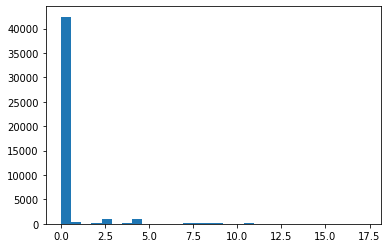

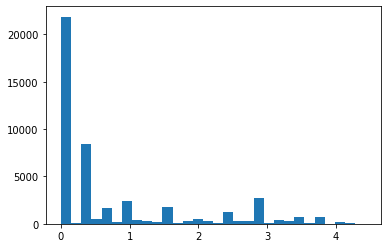

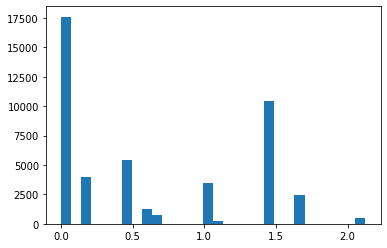

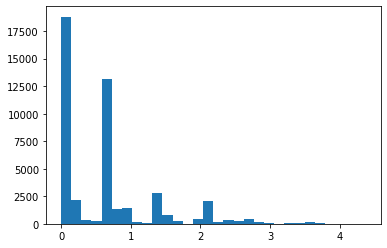

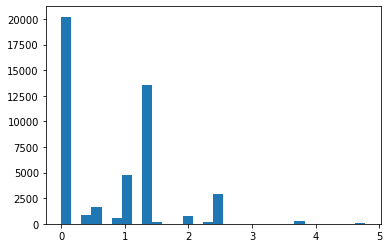

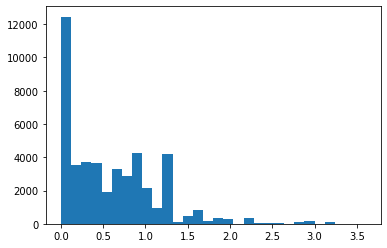

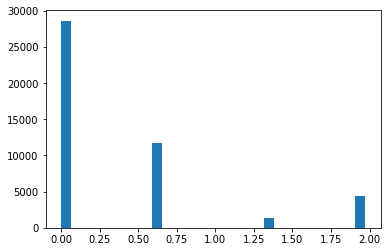

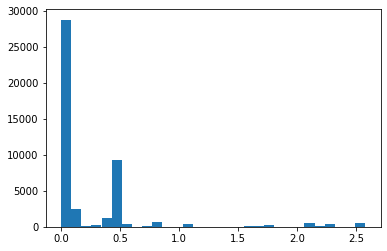

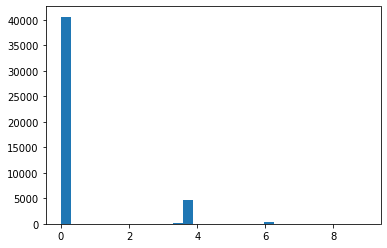

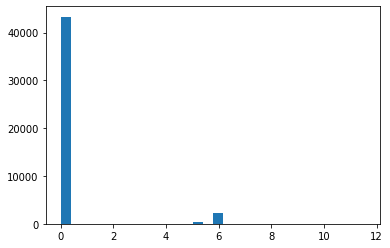

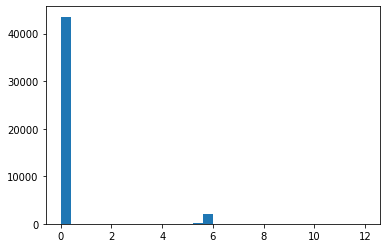

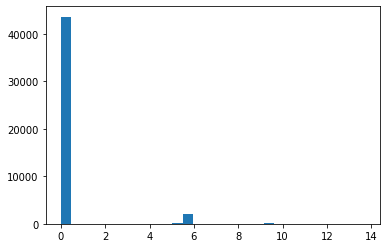

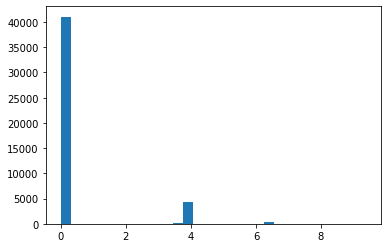

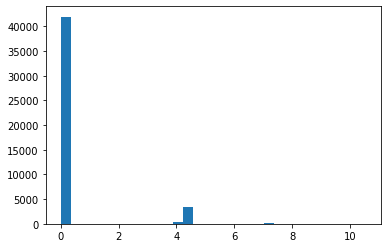

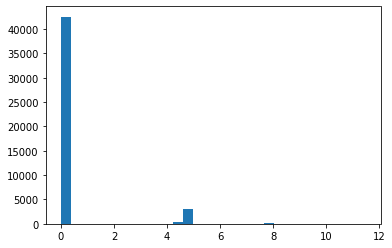

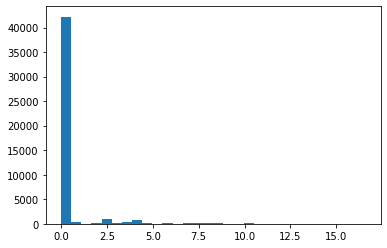

In [54]:
dist_RDD = sessions_pairs_differences.map(lambda x: x[1][:31:2])
distances = np.transpose(np.array(dist_RDD.collect()))
dist_means = []
dist_var = []
for i in distances:
    dist_means.append(np.mean(i))
    dist_var.append(np.var(i))
    plt.figure()
    n, bins, patches = plt.hist(i, 30)
dist_sig = np.sqrt(np.array(dist_var))

### B) Shaping the X and Y arrays for feature selection (and making sure the line order corresponds in both RDD)

#### Joining the sessions_pairs_differences and purchased_items_distance to make  sure that the lines of each RDD match correctly

In [55]:
X_and_Y = sessions_pairs_differences.join(purchased_items_distances).map(lambda x:(x[0], (x[1][:-1], x[1][-1:])))
X_and_Y.take(3)

[((2248680, 788690),
  ((array([0.        , 0.        , 0.58170012, 0.25250162, 0.62598707,
           0.        , 1.32748582, 1.18727826, 0.        , 0.32385953,
           0.        , 1.94951805, 0.        , 0.        , 0.        ,
           0.        , 0.        , 0.        , 0.        , 0.        ,
           0.        , 0.        , 0.        , 0.        , 0.        ,
           0.        , 0.        , 0.        , 0.        , 0.        ,
           0.        , 0.        , 0.58412626, 0.25005925, 0.63367669,
           0.        , 1.3466689 , 1.22611614, 0.        , 0.32128719,
           0.        , 1.94538666, 0.        , 0.        , 0.        ]),),
   (667.8299748120544,))),
 ((2332610, 2209480),
  ((array([0.        , 0.78734822, 3.40421025, 1.9150772 , 1.00794529,
           0.        , 2.88609641, 0.        , 1.3898594 , 2.0588213 ,
           0.10524986, 0.        , 0.        , 0.        , 0.82081761,
           0.        , 3.84757828, 0.        , 0.        , 0.        ,
   

In [56]:
X = X_and_Y.map(lambda x: x[1][0])
Y = X_and_Y.map(lambda x: x[1][1]).map(lambda x: x[0])

testx = X.take(5)
testy = Y.take(5)

for i in range(len(testx)):
    print('x : ' + str(testx[i]))
    print('y : ' + str(testy[i]))
selected_x = X

y = Y.collect()

x : (array([0.        , 0.        , 0.58170012, 0.25250162, 0.62598707,
       0.        , 1.32748582, 1.18727826, 0.        , 0.32385953,
       0.        , 1.94951805, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.58412626, 0.25005925, 0.63367669,
       0.        , 1.3466689 , 1.22611614, 0.        , 0.32128719,
       0.        , 1.94538666, 0.        , 0.        , 0.        ]),)
y : 667.8299748120544
x : (array([0.        , 0.78734822, 3.40421025, 1.9150772 , 1.00794529,
       0.        , 2.88609641, 0.        , 1.3898594 , 2.0588213 ,
       0.10524986, 0.        , 0.        , 0.        , 0.82081761,
       0.        , 3.84757828, 0.        , 0.        , 0.        ,
       6.00333839, 0.        , 0.        , 4.82134467, 0.        ,
       0.        , 0.      

In [57]:
#in the feature selection algorithms the computation of the scores of the features is done in parallel, 
#so it is more interesting to have each feature be a line of the rdd
X_matrix = np.transpose(np.array(selected_x.collect()))
X_t = sc.parallelize(X_matrix).map(lambda x: x[0])

## C) Feature selection algorithms : Mrmr and forward feature selection

In [58]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score


In [59]:
def get_score(X,y):
    #function used in the mrmr algorithm to compute how well a linear regression model, using as input one feature (the array X), can predict the output (y)
    #the score is computed as the mean of the scores of a 3 fold crossvalidation
    model = LinearRegression()
    x = np.array(X).reshape(-1, 1)
    scores = cross_val_score(model, x, y, cv=3)  
    return scores.mean()

In [60]:
def get_corr(x,y):
    # computes the pearson correlation of to arrays x and y
    score = np.abs(scipy.stats.pearsonr(x, y)[0])
    
    return score

In [61]:
def get_mrmr_score_spark(x):
    
    #given a feature x, the function computes the score of x as a difference between its "relevency" score and 
    #"redundancy" score

    # Retrieve content of broadcasted values
    y = broadcast_y.value
    selected_features_values = broadcast_selected_features_values.value
    
    # Get correlation score between feature x and output y (relevance)
    
    score_x_y_s = get_score(x,y)
    #print('score x-y : ' + str(score_x_y_s))
    
    n_selected_features = selected_features_values.shape[0]
    
    # If some features have already been selected
    if n_selected_features>0:
        
        # Get corrrelation scores between x and each feature already selected (redundancy)
        score_features_x_s = np.zeros(n_selected_features, dtype=float)
        
        for j in range(n_selected_features):
            score_x_s_j = get_corr(x, selected_features_values[j,:])
            #print(score_x_s_j )
                
            score_features_x_s[j] = score_x_s_j
                
        # Final score is relevance to output feature - average redundancy with already selected features
        score_x_y_s = score_x_y_s - np.mean(score_features_x_s)
        
    return score_x_y_s

In [62]:
def ffs_score_spark(x):
    #given a candidate feature x, the function computes the score for the forward selection algorithm : 
    #the score is the mean of the crossvalidation scores of a linear regression model trained on the union of the candidate 
    #feature and the already selected features
    
    # Retrieve content of broadcasted values
    y = broadcast_y.value
    selected_features_values = broadcast_selected_features_values.value   
    all_features = list(list(item) for item in selected_features_values)
    #the candidate feature is added to the list of selected features
    all_features.append(x)
    #the model needs a dataset where features are columns and observations (sessions) are lines
    X = np.transpose(np.array(all_features))
    model = LinearRegression()
    scores = cross_val_score(model, X, y, cv=3)
    return(scores.mean())    


In [65]:
n_features = 45
K = 10 #number of selected features

remaining_features_indices = list(range(n_features))
selected_features_indices = []
broadcast_y = sc.broadcast(y)
features_scores = []
choose_mrmr = False #if true, the mrmr algorithm is used for feature selection, if false the forward feature selection is computed
if choose_mrmr:
    get_feature_score = get_mrmr_score_spark
else:
    get_feature_score = ffs_score_spark
    
for k in range(K):
    print("Step: "+str(k))

    # Get the subset of selected features values, and cast as an array
    selected_features_values = X_t.zipWithIndex().filter(lambda x: x[1] in selected_features_indices).map(lambda x: x[0]).collect()
    selected_features_values = np.array(selected_features_values)

    # Broadcast selected_features_values 
    broadcast_selected_features_values = sc.broadcast(selected_features_values)
    # mRMR scores are computed by first filtering `X_t` to remove already selected features, and then mapping 
    # each remaining feature using the `get_mrmr_score_spark` function
    
    scores = X_t.zipWithIndex().filter(lambda x: x[1] in remaining_features_indices).map(lambda x:get_feature_score(x[0])).collect()

    scores = np.array(scores)
    #at each iteration, the feature with the highest score is added to the selected features (and remove from the remaining ones)
    index_max_score_features = np.argmax(scores)
    max_score = scores[index_max_score_features]
    features_scores.append(max_score)

    selected_features_indices.append(remaining_features_indices[index_max_score_features])

    del(remaining_features_indices[index_max_score_features])

print('features scores : ' + str(features_scores))

Step: 0
Step: 1
Step: 2
Step: 3
Step: 4
Step: 5
Step: 6
Step: 7
Step: 8
Step: 9
features scores : [0.09883253917665509, 0.116161524324553, 0.12233614367252547, 0.12751950725210784, 0.13224600545520226, 0.13529431817639437, 0.13738588041942948, 0.13890938586790372, 0.13983057784244135, 0.14075869631700613]


In [64]:
mrmr_features = selected_features_indices
mrmr_features

[7, 15, 13, 8, 5, 1, 18, 3, 0, 10]

In [66]:
ffs_features = selected_features_indices
ffs_features

[7, 33, 34, 14, 42, 2, 11, 9, 37, 0]

# 3) Item purchase prediction model

In [67]:
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import col
from pyspark.ml.feature import BucketedRandomProjectionLSH
import time

#### Creating the table of all the sessions each items appears in

In [68]:
items_list = items_dataset.map(lambda x:(x[0])) #get all the item ids
sessions_list = sessions_dataset.map(lambda x: (x[0], [item[0] for item in x[1]])) # (session_id, [list of item ids in session])
flat_sessions_list = sessions_list.flatMap(lambda x:[(item, [x[0]]) for item in x[1]]) # [(item id1, session id1), (item id, session id2)...]
items_sess_table = flat_sessions_list.reduceByKey(lambda x,y: x+y) # reduce by key (with key = item id), to get (item id, [list of session ids with item])
items_sess_table.cache()
items_sess_table.take(2)
items_sess_table_list = items_sess_table.collect()

#### Set train and test data

In [69]:
def select_index(x):
    #function used to select the features by using the list of indices computed during the feature selection section
    index_list = broadcasted_index.value
    res = []
    for i in index_list:
        res.append(x[i])
    return res

In [118]:
mrmr_features.sort()
ffs_features.sort()
ffs_features

[0, 2, 7, 9, 11, 14, 33, 34, 37, 42]

In [119]:
features = ffs_features

In [120]:
broadcasted_index = sc.broadcast(features)
dataset = standardized_sessions_dataset.map(lambda x: (x[0], select_index(x[1]))) # we use only the selected features
train_data = spark.createDataFrame(dataset.map(lambda x: (x[0], Vectors.dense(x[1]))), ['id', 'features']) 

test_dataset = test_standardized_sessions_dataset.map(lambda x: (x[0], select_index(x[1])))
test_data = spark.createDataFrame(test_dataset.map(lambda x: (x[0], Vectors.dense(x[1]))), ['id', 'features'])

In [121]:
reduced_test_data = test_data.sample(False, 0.055)

In [91]:
reduced_test_data.show()

+-------+--------------------+
|     id|            features|
+-------+--------------------+
| 910430|[0.04364460273238...|
|2507050|[0.04364460273238...|
|1735940|[0.04364460273238...|
| 793940|[0.04364460273238...|
|4363850|[0.04364460273238...|
| 874760|[0.04364460273238...|
|1541550|[0.04364460273238...|
|1426700|[0.04364460273238...|
| 280190|[0.04364460273238...|
|  40120|[0.04364460273238...|
|2604290|[0.04364460273238...|
|1439900|[0.04364460273238...|
| 147370|[0.04364460273238...|
|1938510|[0.04364460273238...|
|1536640|[0.04364460273238...|
|1162560|[0.04364460273238...|
|2156770|[0.04364460273238...|
| 736380|[0.04364460273238...|
|2193560|[0.04364460273238...|
| 443800|[0.04364460273238...|
+-------+--------------------+
only showing top 20 rows



In [82]:
standardized_sessions_dataset.unpersist()

PythonRDD[94] at RDD at PythonRDD.scala:53

In [122]:
#computation of the truth table (the rdd with key=session id from test_data, value=item_id of the purchased item)
test_truth_table = P_sessions_RDD.map(lambda x: (x[1][0], x[0])).join(test_data.rdd.map(lambda x: (x[0], x[1]))).map(lambda x: (x[0], x[1][0]))
test_truth_table.take(3)

[(1344, 10061), (2100, 13403), (6156, 20629)]

In [123]:
N_test_sessions = reduced_test_data.count()

In [124]:
print('train dataset size : ' + str(train_data.count()))
print('test dataset size : ' + str(N_test_sessions))

train dataset size : 92044
test dataset size : 1099


#### KNN model using bucketed random projection LSH

In [125]:
#set model
brp = BucketedRandomProjectionLSH(inputCol="features", outputCol="hashes", seed=12345, bucketLength=50.0)
#fit model
model = brp.fit(train_data)

#### Compute item scores for each session

In [134]:
def compute_1_item_score(item_sess):
    #function that takes as input the sessions in which an item appears in, and which computes the score associated with the purchase of the item,
    # using the broadcasted array with the neighbors of the session of interest, and their similarity to the session
    neighbors = broadcasted_neighbors.value
    filtered_neighbors = filter(lambda x: x[0] in item_sess, neighbors)
    relevent_neighbors_sim = []
    for n in filtered_neighbors:
        relevent_neighbors_sim.append(n[1])
    score = sum(relevent_neighbors_sim)
    return score   

In [126]:
test_sessions = reduced_test_data.rdd.map(lambda x: (x[0], x[1])).collect()
#test_sessions 

In [128]:
len(test_sessions)

1099

In [142]:
K = 50
sessions_top100 = []
use_map_not_loop = True
write_to_file = True
#session = test_sessions[0]
l = 0
start_time=time.time()

for session in test_sessions: 
    l += 1
    print (str(l) + ' : ' + str(session[0]))
    sess_id = session[0]
    sess_features = session[1]
    scores = []
    neighbors = model.approxNearestNeighbors(train_data, sess_features, K)
    neighbors = neighbors.withColumn('sim', 1.0/(neighbors.distCol+1)).select('id', 'sim')
    neighbors_array = neighbors.rdd.map(lambda x: [x[0],x[1]]).collect()
    broadcasted_neighbors = sc.broadcast(neighbors_array)
    if use_map_not_loop:
        items_scored = items_sess_table.map(lambda x: (x[0], compute_1_item_score(x[1]))).collect()
    
    else:
        items_scored = []
        for item in items_sess_table_list:
            items_scored.append((item[0], compute_1_item_score(item[1])))
                   
    items_scored.sort(reverse=True, key = lambda x: x[1])
    items_scored = [x[0] for x in items_scored[:100]]  
    sessions_top100.append((session[0], items_scored)) 

if write_to_file:
    f = open("results.txt", "w")
    f.write("\n".join(map(lambda x: str(x), sessions_top100)))
    f.close()

    
stop_time = time.time()
tot_time = stop_time - start_time
sessions_top100_RDD = sc.parallelize(sessions_top100)

1 : 2073930
2 : 1429550
3 : 3153640
4 : 147490
5 : 4158190
6 : 2726550
7 : 1269630
8 : 4286580
9 : 138980
10 : 3643750
11 : 4076420
12 : 908150
13 : 4369910
14 : 4108310
15 : 817290
16 : 190260
17 : 1416780
18 : 1917850
19 : 1320660
20 : 2438360
21 : 475390
22 : 2278340
23 : 4270
24 : 3259380
25 : 443800
26 : 3053940
27 : 234190
28 : 3111630
29 : 2178700
30 : 1972500
31 : 816580
32 : 415430
33 : 3940610
34 : 3458180
35 : 2209040
36 : 3899360
37 : 518020
38 : 2159480
39 : 1249160
40 : 2851500
41 : 1506160
42 : 1506520
43 : 3811270
44 : 4026680
45 : 4019950
46 : 3270020
47 : 3101710
48 : 1748860
49 : 1862390
50 : 3825270
51 : 2136260
52 : 3432580
53 : 1839130
54 : 3573270
55 : 2061100
56 : 3667080
57 : 2626100
58 : 4267350
59 : 2752230
60 : 2947260
61 : 4163640
62 : 2245470
63 : 3913780
64 : 4000920
65 : 2050040
66 : 1255530
67 : 2586350
68 : 2803740
69 : 1794980
70 : 2406240
71 : 4434190
72 : 3666930
73 : 3781180
74 : 3828140
75 : 4415570
76 : 914800
77 : 2086510
78 : 798270
79 : 344793

In [146]:
tot_time

6988.742899894714

In [102]:
results_mrmr = sessions_top100

In [143]:
results_ffs = sessions_top100

### Evaluation of the prediction

In [105]:
def score_sess_pred(sess):
    top100 = sess[0]
    p_item = sess[1]
    if p_item not in top100:
        res = 0
    else:
        res = 1.0/(top100.index(p_item) + 1.0)
    return res

In [148]:
eval_RDD = sessions_top100_RDD.join(test_truth_table)
scored_pred_ffs = eval_RDD.map(lambda x: score_sess_pred(x[1]))
tot_score_ffs = scored_pred_ffs.reduce(lambda x, y: x+y)/N_test_sessions

In [149]:
tot_score_ffs

0.06351844189172526

In [152]:
tot_score_mrmr


0.04130246216905554

In [153]:
av_rank_mrmr = 1.0/tot_score_mrmr
av_rank_ffs = 1.0/tot_score_ffs
print('final score mrmr :' + str(av_rank_mrmr))
print('final score ffs :' + str(av_rank_ffs))

final score mrmr :24.211631643336165
final score ffs :15.743459225662667
